In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time

import cv2
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

import import_ipynb
from functions import get_hog_features, bin_spatial, color_hist, slide_window, draw_boxes, convert_image

importing Jupyter notebook from functions.ipynb


In [2]:
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
import os
import random

def get_dataset(rootdir):
    images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))
                
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

In [4]:
rootdir = './vehicles'
cars = get_dataset(rootdir)
print(len(cars))

8792


In [5]:
rootdir = './non-vehicles'
notcars = get_dataset(rootdir)
print(len(notcars))

8921


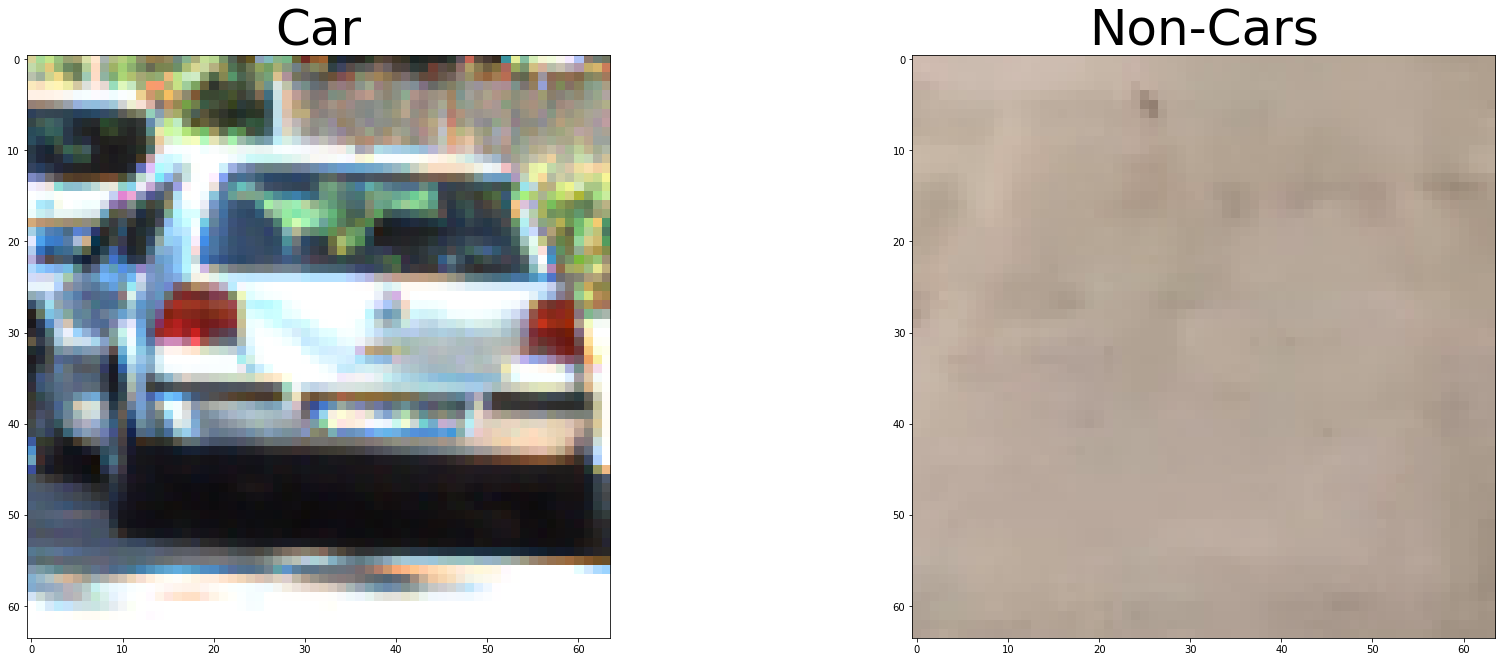

In [6]:
image1 = random.choice(cars)
image2 = random.choice(notcars)
show_images(image1, "Car", image2, "Non-Cars")

In [7]:
class Parameters():
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 8    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    #y_start_stop = [None, None] # Min and max in y to search in slide_window()
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=8, orient=9, 
                 pix_per_cell=8, cell_per_block=2, hog_channel=0, scale = 1.5,hist_range = (0, 256),
                 spatial_feat=True, hist_feat=True, hog_feat=True):
        # HOG parameters
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.scale = scale
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.hist_range = hist_range

In [26]:
params = Parameters(
            color_space = 'YCrCb',
            spatial_size = (16, 16),
            orient = 8,
            pix_per_cell = 8,
            cell_per_block = 2,
            hog_channel = 'ALL',
            hist_bins = 32,
            scale = 1.5,
            spatial_feat=True, 
            hist_feat=True, 
            hog_feat=True
        )

In [27]:

def extract_features(img, params):
        file_features = []
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(img, params.color_space)    

        if params.spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=params.spatial_size)
            file_features.append(spatial_features)
        if params.hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=params.hist_bins)
            file_features.append(hist_features)
        if params.hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if params.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        params.orient, params.pix_per_cell, params.cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params.orient, 
                            params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        # Return list of feature vectors
        return np.concatenate(file_features)

Text(0.5, 0, 'Non-Car Spatial Features')

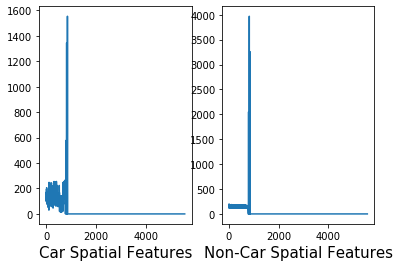

In [28]:

vehicle = image1
non_vehicle = image2

car_spatial_features = extract_features(vehicle, params)
notcar_spatial_features = extract_features(non_vehicle, params)
plt.figure()
plt.subplot(121)
plt.plot((car_spatial_features))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(notcar_spatial_features)
plt.xlabel("Non-Car Spatial Features",fontsize=15)

In [29]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8750
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

Text(0.5, 0, 'Non-Car Spatial Features')

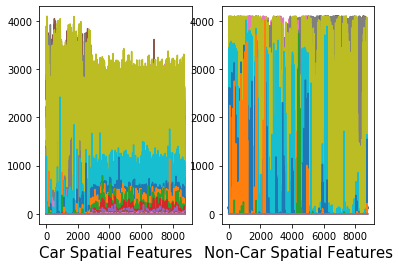

In [30]:
car_features = list(map(lambda img: extract_features(img, params), cars))

notcar_features = list(map(lambda img: extract_features(img, params), notcars))

plt.figure()
plt.subplot(121)
plt.plot((car_features))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(notcar_features)
plt.xlabel("Non-Car Spatial Features",fontsize=15)

In [31]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [32]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568


In [33]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

11.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9923


In [34]:
# Define a single function that can extract features using hog sub-sampling and make predictions
'''def find_cars(img, svc, scaler, params,y_start_stop=[400, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85)):
    """"
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    windows_list = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window,params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = svc.predict(scaled_features)
        if pred == 1:
            windows_list.append(window)
    return windows_list'''

def find_cars(img, ystart, ystop, svc, scaler, params, cells_per_step = 1):
    draw_img = np.copy(img)
    cspace = params.color_space
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    if params.scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/params.scale), np.int(imshape[0]/params.scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=params.spatial_size)
            hist_features = color_hist(subimg, nbins=params.hist_bins, bins_range=params.hist_range)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*params.scale )
                ytop_draw = np.int(ytop*params.scale )
                win_draw = np.int(window*params.scale )
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


from scipy.ndimage.measurements import label

def heat_threshold(img, threshold, svc, X_scaler, windows_list, params):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap


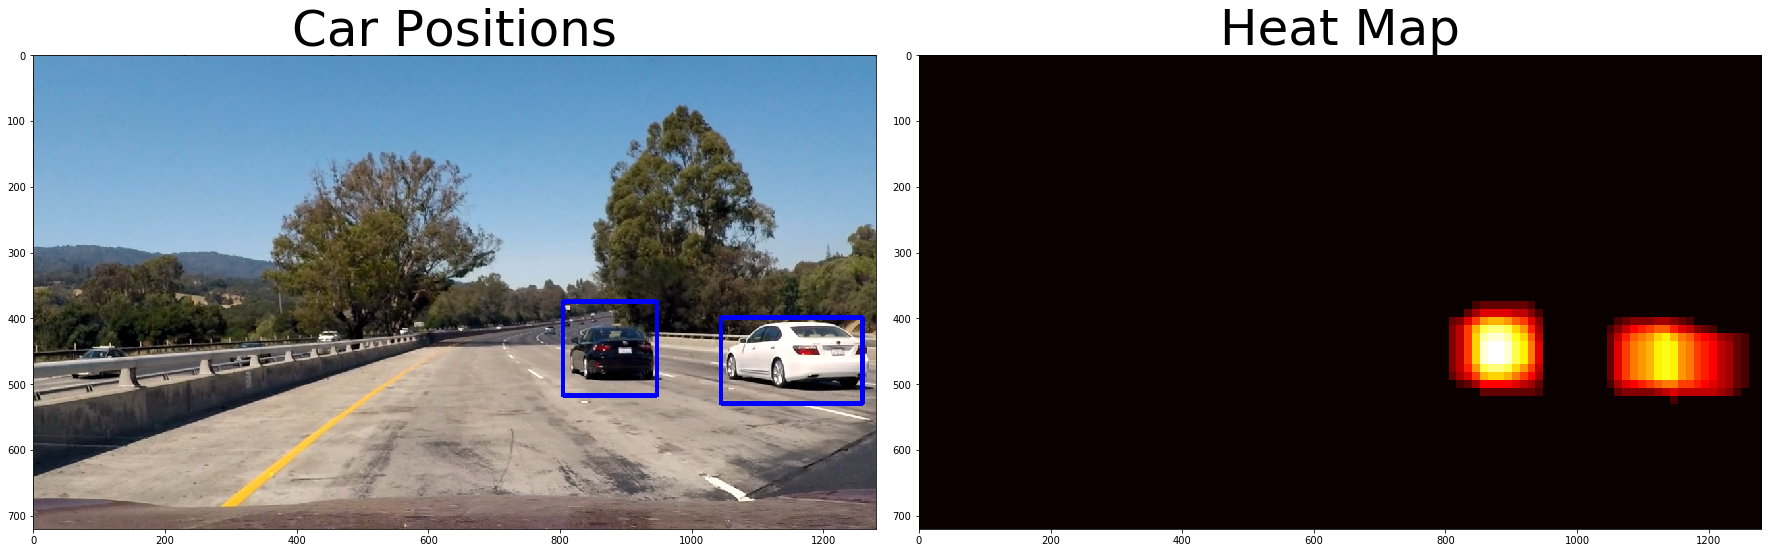

In [36]:
ystart = 350
ystop = 656
threshold = 1
img = mpimg.imread('test1.jpg')
windows_list = find_cars(img, ystart, ystop, svc, X_scaler, params, cells_per_step = 1)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [37]:
def pipeline(img):
    threshold = 1 
    windows_list = find_cars(img, ystart, ystop, svc, X_scaler, params, cells_per_step = 1)
    draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)
    
    return draw_img

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def process_image(img):
    return pipeline(img)

white_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
Wall time: 1h 1min 8s
